# Logistic Regression (Olive Oils dataset)

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


In [7]:
# import local utility functions
import sys
sys.path.append('../utils')
import utils as utl

## Load raw data and plot

In [8]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/olive_oils/FTIR_olive_oils.csv')
data.head(5)

,798.892,800.8215,802.751,804.6805,806.61,808.5395,810.469,812.3985,814.328,816.2575,...,1885.2305,1887.16,1889.0895,1891.019,1892.9485,1894.878,1896.8085,code,label,sample
0,0.127523,0.127950,0.129282,0.131174,0.133590,0.136426,0.139358,0.142219,0.144805,0.146764,...,0.012279,0.012158,0.011884,0.011716,0.011583,0.011315,0.011304,1,Greece,1
1,0.126498,0.127131,0.128511,0.130340,0.132527,0.135309,0.138353,0.141150,0.143630,0.145624,...,0.006467,0.006223,0.005720,0.005518,0.005494,0.005321,0.005426,1,Greece,1
2,0.130412,0.130675,0.132017,0.133824,0.136095,0.138944,0.141723,0.144136,0.146431,0.148389,...,0.007548,0.007391,0.007176,0.006843,0.006551,0.006398,0.006582,1,Greece,2
3,0.130022,0.130407,0.132018,0.134007,0.136271,0.138875,0.141481,0.144075,0.146553,0.148443,...,0.006059,0.005933,0.005507,0.005347,0.005349,0.005133,0.005222,1,Greece,2
4,0.128602,0.128790,0.130022,0.132012,0.134427,0.137070,0.139646,0.142338,0.144923,0.146958,...,0.010594,0.010379,0.010287,0.010127,0.009966,0.009760,0.009649,1,Greece,3


In [9]:
# shuffle data rows
data = data.sample(frac=1)

Greece: blue
Italy: red
Portugal: green
Spain: orange


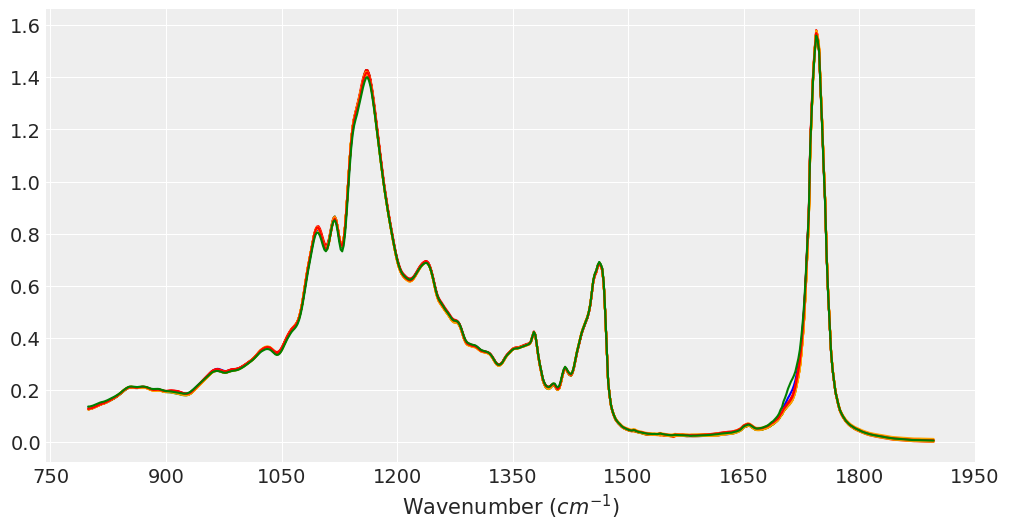

In [16]:
# name of column containing the labels
label_col = 'label'

# number of non-data columns at right of dataframe
non_data_cols = -3

# list of class labels
class_labels = utl.get_class_labels(data, label_col)

# plot dataframe
utl.plot_data(data, non_data_cols, label_col, 20)

In [11]:
# number of samples from each class
data[label_col].value_counts()

Spain       50
Italy       34
Greece      20
Portugal    16
Name: label, dtype: int64

In [12]:
# generate training and test sets
train_data, test_data = train_test_split(data, test_size=0.33, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [13]:
test_data.shape

(40, 573)

In [14]:
train_data.shape

(80, 573)

# Model definition (Multiple Logistic Regression)
The following statistical model is assumed:

\begin{equation}
\alpha \sim \mathcal{N}(\mu_{\alpha},\,\sigma^{2}_{\alpha}) \\
\beta \sim \mathcal{N}(\mu_{\beta},\,\sigma^{2}_{\beta}) \\
\theta = softmax(\alpha+\beta X) \\
y \sim Categorical(\theta)
\end{equation}

In [15]:
# get Y labels and standardize data
Y = pd.Categorical(train_data[label_col]).codes
x_n = train_data.columns[:non_data_cols]
x_s = train_data[x_n].values
x_s = utl.standardize(x_s)

In [23]:
train_data[label_col].value_counts()

Spain       33
Italy       25
Greece      12
Portugal    10
Name: label, dtype: int64

In [24]:
import theano.tensor as tt

with pm.Model() as model_mlr: 
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=len(class_labels))
    beta = pm.Normal('beta', mu=0, sd=1, shape=(len(x_n), len(class_labels)))
                     
    mu = pm.Deterministic('mu', alpha + pm.math.dot(x_s, beta))
                     
    theta = tt.nnet.softmax(mu)
                     
    y_pred = pm.Categorical('y_pred', p=theta, observed=Y)
                     
    trace_mlr = pm.sample(1000, init='adapt_diag', random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [16:49<00:00,  2.97draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


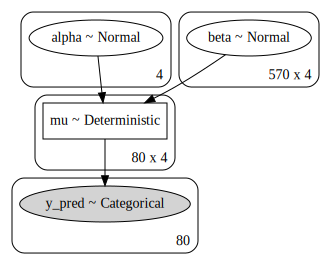

In [25]:
pm.model_to_graphviz(model_mlr)

# Model evaluation

In [26]:
varnames = ['alpha', 'beta']
coef = az.summary(trace_mlr, varnames)
coef

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.371,0.462,-1.292,0.448,0.042,0.029,124.0,124.0,125.0,194.0,1.01
alpha[1],0.383,0.460,-0.510,1.210,0.041,0.029,125.0,125.0,126.0,199.0,1.01
alpha[2],-0.563,0.461,-1.446,0.290,0.041,0.029,125.0,125.0,126.0,193.0,1.01
alpha[3],0.665,0.461,-0.235,1.502,0.041,0.029,125.0,125.0,126.0,195.0,1.01
"beta[0,0]",0.023,1.003,-2.012,1.804,0.042,0.029,581.0,581.0,580.0,848.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
"beta[568,3]",0.005,0.987,-1.849,1.804,0.039,0.028,638.0,638.0,636.0,898.0,1.00
"beta[569,0]",0.025,0.954,-1.681,1.817,0.046,0.033,426.0,426.0,426.0,578.0,1.00
"beta[569,1]",-0.013,1.020,-1.909,1.864,0.043,0.030,573.0,573.0,573.0,770.0,1.00
"beta[569,2]",0.016,0.947,-1.865,1.702,0.043,0.030,484.0,484.0,487.0,632.0,1.00


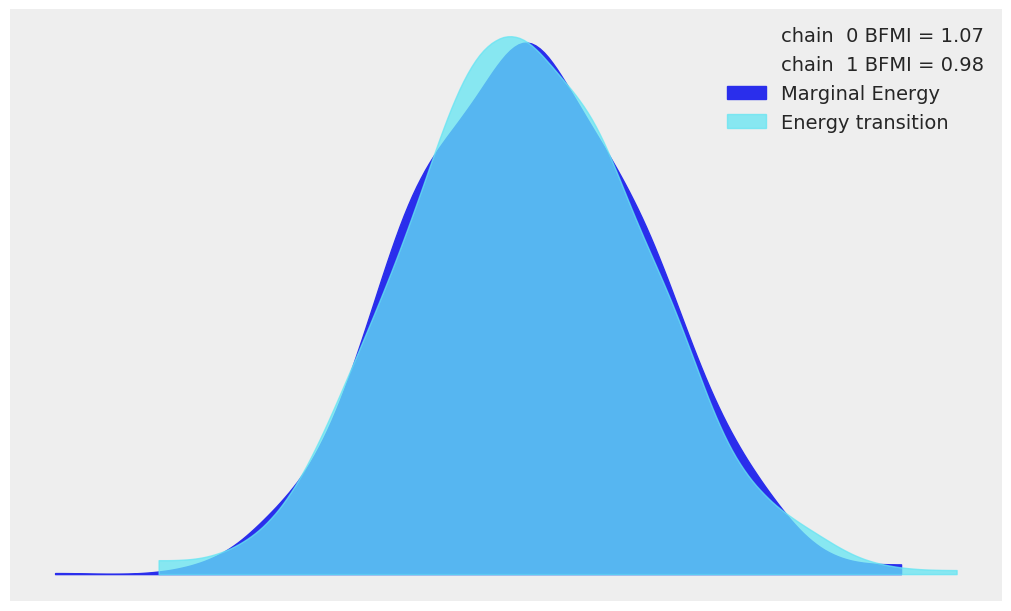

In [27]:
#az.plot_forest(trace_mlr, var_names=varnames, combined=True);
az.plot_energy(trace_mlr, figsize=(10, 6));

In [35]:
# correct predictions on training data
utl.softmax_score(train_data, trace_mlr, label_col)

total  : 80
correct: 33
error  : 47
score  : 41.2%


# Save inference results

In [37]:
pm.backends.text.dump('./traces/trace_olive_oils', trace_mlr)